In [2]:
import pandas as pd
from docx import Document
import re
import pandas as pd
import torch
from transformers import BigBirdTokenizer,BigBirdModel,BigBirdForSequenceClassification
import PyPDF2
from torch import Tensor

In [3]:
Data_csv = pd.read_csv("/home/ubuntu/working_directory/Bert_experimentation/new_dataframe_50000_100000.csv")

In [4]:
Data_csv.drop('Unnamed: 0', axis=1, inplace=True)
Data_csv

,FileName,text,Level
0,15031-4983-FullBook.docx,"Learner Choice, Learning Voice\n\n\nLearner Vo...",Level 1
1,15031-4984-FullBook.docx,\n\nExistentialism: A Philosophical Inquiry\n\...,Level 1
2,15031-4985-FullBook.docx,"""The editors of this volume are the top practi...",Level 1
3,15031-4986-FullBook.docx,Black Power Music!\n\nBlack Power Music!: Prot...,Level 1
4,15031-4994-FullBook.docx,"""A masterful and highly accessible overview of...",Level 1
...,...,...,...
690,15032-5743-FullBook.docx,Student-Centred Approaches to Russian Language...,Level 3
691,15032-5749-FullBook.docx,Ancient and Early Medieval Kingdoms of the Pam...,Level 3
692,15032-5789-FullBook.docx,The Acquisition of English Grammar and Phonolo...,Level 3
693,15032-5829-FullBook.docx,"\n‘New concepts, new words for them, new actio...",Level 3


In [5]:
Data_csv["Level"].value_counts()

Level 1    577
Level 2     91
Level 3     27
Name: Level, dtype: int64

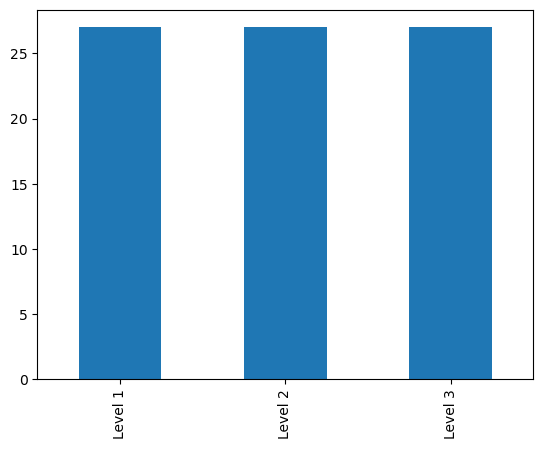

In [6]:
sample_df = Data_csv.groupby("Level").apply(lambda x: x.sample(27))
selected_df = sample_df["Level"].value_counts().plot(kind="bar")

In [7]:
tokenizer = BigBirdTokenizer.from_pretrained('google/bigbird-roberta-base')

In [8]:
def split_tokens_into_smaller_chunks(input_id: Tensor,att_mask: Tensor, chunk_size: int, stride: int, minimal_chunk_length: int):
    input_id_chunks = [input_id[i : i + chunk_size] for i in range(0, len(input_id), stride)]
    mask_chunks = [att_mask[i : i + chunk_size] for i in range(0, len(att_mask), stride)]
    if len(input_id_chunks) > 1:
        # ignore chunks with less than minimal_length number of tokens
        input_id_chunks = [x for x in input_id_chunks if len(x) >= minimal_chunk_length]
        mask_chunks = [x for x in mask_chunks if len(x) >= minimal_chunk_length]
    return input_id_chunks, mask_chunks


def add_special_tokens_at_beginning_and_end(input_id_chunks: list[Tensor], mask_chunks: list[Tensor]) -> None:
    """
    Adds special CLS token (token id = 101) at the beginning.
    Adds SEP token (token id = 102) at the end of each chunk.
    Adds corresponding attention masks equal to 1 (attention mask is boolean).
    """
    for i in range(len(input_id_chunks)):
        # adding CLS (token id 101) and SEP (token id 102) tokens
        input_id_chunks[i] = torch.cat([Tensor([101]), input_id_chunks[i], Tensor([102])])
        # adding attention masks  corresponding to special tokens
        mask_chunks[i] = torch.cat([Tensor([1]), mask_chunks[i], Tensor([1])])

def add_padding_tokens(input_id_chunks: list[Tensor], mask_chunks: list[Tensor]) -> None:
    """Adds padding tokens (token id = 0) at the end to make sure that all chunks have exactly 512 tokens."""
    for i in range(len(input_id_chunks)):
        # get required padding length
        pad_len = 512 - input_id_chunks[i].shape[0]
        # check if tensor length satisfies required chunk size
        if pad_len > 0:
            # if padding length is more than 0, we must add padding
            input_id_chunks[i] = torch.cat([input_id_chunks[i], Tensor([0] * pad_len)])
            mask_chunks[i] = torch.cat([mask_chunks[i], Tensor([0] * pad_len)])
def stack_tokens_from_all_chunks(input_id_chunks: list[Tensor], mask_chunks: list[Tensor]) -> tuple[Tensor, Tensor]:
    input_ids = torch.stack(input_id_chunks)
    attention_mask = torch.stack(mask_chunks)
    return input_ids.long(), attention_mask.int()

In [39]:
new_chunk_df = pd.DataFrame()
total_chunks = []   
total_fnames = []
total_labels = []
total_chunk_counts = []
input_df = []
attention_mask_df = []
labels_df = []
chunks_count = 1
chunk_size = 510 
stride = 256
minimal_chunk_length = 1
label2id = {"Level 1": 0, "Level 2": 1, "Level 3": 2}

for idx in range(sample_df.shape[0]):
    x = sample_df["text"].iloc[idx]
    label = label2id[sample_df.iloc[idx]["Level"]]
    label_vec = pd.get_dummies([label], columns=label2id.values()).values.squeeze()
    tokens = tokenizer(x, add_special_tokens=True, truncation=False, return_tensors="pt")
    input_id_chunks, mask_chunks = split_tokens_into_smaller_chunks(tokens["input_ids"][0],tokens["attention_mask"][0], chunk_size, stride, minimal_chunk_length)
    add_special_tokens_at_beginning_and_end(input_id_chunks, mask_chunks)
    add_padding_tokens(input_id_chunks, mask_chunks)
    input_ids, attention_mask = stack_tokens_from_all_chunks(input_id_chunks, mask_chunks)
    input_df.append(input_ids)
    attention_mask_df.append(attention_mask)
    labels_df.append(label_vec)

    

In [42]:
input_df[0].shape

torch.Size([483, 512])

In [13]:
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence
class CustomDataset(Dataset):
    def __init__(self, data, label2id, tokenizer, chunk_size, stride, minimal_chunk_length):
        self.data = data
        self.label2id = label2id
        self.tokenizer = tokenizer
        self.chunk_size = chunk_size
        self.stride = stride
        self.minimal_chunk_length = minimal_chunk_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data["text"].iloc[index]
        label = self.label2id[self.data.iloc[index]["Level"]]
        tokens = self.tokenizer(x, add_special_tokens=True, truncation=False, return_tensors="pt")
        input_id_chunks, mask_chunks = split_tokens_into_smaller_chunks(tokens["input_ids"][0], tokens["attention_mask"][0], self.chunk_size, self.stride, self.minimal_chunk_length)
        add_special_tokens_at_beginning_and_end(input_id_chunks, mask_chunks)
        add_padding_tokens(input_id_chunks, mask_chunks)
        input_ids, attention_mask = stack_tokens_from_all_chunks(input_id_chunks, mask_chunks)

        return {
            'input_ids': input_ids.squeeze(),
            'attention_mask': attention_mask.squeeze(),
            'label': label
        }


In [14]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, data, label2id, tokenizer, chunk_size, stride, minimal_chunk_length):
        self.data = data
        self.label2id = label2id
        self.tokenizer = tokenizer
        self.chunk_size = chunk_size
        self.stride = stride
        self.minimal_chunk_length = minimal_chunk_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data["text"].iloc[index]
        label = self.label2id[self.data.iloc[index]["Level"]]

        tokens = self.tokenizer(x, add_special_tokens=True, truncation=False, return_tensors="pt")
        input_id_chunks, mask_chunks = split_tokens_into_smaller_chunks(tokens["input_ids"][0], tokens["attention_mask"][0], self.chunk_size, self.stride, self.minimal_chunk_length)
        add_special_tokens_at_beginning_and_end(input_id_chunks, mask_chunks)
        add_padding_tokens(input_id_chunks, mask_chunks)
        input_ids, attention_mask = stack_tokens_from_all_chunks(input_id_chunks, mask_chunks)

      # Padding
        input_id_chunks = pad_sequence(input_id_chunks, batch_first=True, padding_value=self.tokenizer.pad_token_id)
        mask_chunks = pad_sequence(mask_chunks, batch_first=True, padding_value=0)

        label_vec = pd.get_dummies([label], columns=self.label2id.values()).values.squeeze()

        return {
            'input_ids': input_id_chunks,
            'attention_mask': mask_chunks,
            'label': torch.tensor(label_vec, dtype=torch.float32)
        }


In [15]:
label2id = {"Level 1": 0, "Level 2": 1, "Level 3": 2}
chunks_count = 1
chunk_size = 510 
stride = 256
minimal_chunk_length = 1
train_dataset = CustomDataset(sample_df, label2id, tokenizer, chunk_size, stride, minimal_chunk_length)


In [16]:
len(train_dataset)

81

In [18]:
len(train_dataset)
train_dataset[0]['input_ids'].shape
# train_dataset[0]['input_ids']

torch.Size([381, 512])

In [32]:
dimension_tensor = torch.randn(556, 512)  # Replace this with your actual tensor
label = 1  # Replace this with your actual label

# Convert the tensor into a list of tensors of size ([512]) with the same label
dimension_list = [dimension_tensor[i] for i in range(dimension_tensor.size(0))]
label_list = [label] * dimension_tensor.size(0)

# Print the first tensor and label from the list
print("Dimension Tensor:", dimension_list[0])
print("Label:", label_list[0])

AttributeError: 'CustomDataset' object has no attribute 'shape'

In [27]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=4,
                                           pin_memory=True,
                                           shuffle=False, 
                                           )
# test_loader = torch.utils.data.DataLoader(test_dataset,
#                                            batch_size=4,
#                                            pin_memory=True,
#                                            )

In [28]:
tokenizer = BigBirdTokenizer.from_pretrained('google/bigbird-roberta-base')
model = BigBirdForSequenceClassification.from_pretrained('google/bigbird-roberta-base', 
                                                         num_labels=3)
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

EPOCHS = 5
LEARNING_RATE = 0.0000025 ######
BATCH_SIZE = 4
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.04) #####
scheduler = get_linear_schedule_with_warmup(optimizer, 
             num_warmup_steps=50, ########
            num_training_steps=len(train_loader)*EPOCHS )   

Some weights of the model checkpoint at google/bigbird-roberta-base were not used when initializing BigBirdForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BigBirdForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BigBirdForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BigBirdForSequenceClassifica

In [29]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")


In [30]:
from torch.nn.utils import clip_grad_norm_
# from tqdm import tqdm
from tqdm.notebook import tqdm

import numpy as np
import math

train_loss_per_epoch = []
val_loss_per_epoch = []

model = model.to(device)
for epoch_num in range(EPOCHS):
    print('Epoch: ', epoch_num + 1)
    '''
    Training
    '''
    model.train()
    train_loss = 0
    for step_num, batch_data in enumerate(tqdm(train_loader,desc='Training')):
        # tqdm_desc = f'Training ({step_num+1}/{train_loader_length})'
        # print("batch>>>",batch_data)
        input_ids, att_mask, labels = batch_data["input_ids"].to(device),batch_data["attention_mask"].to(device),batch_data["label"].to(device)

        # input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)
        # print("logits***:", output["logits"])
        
        loss = output.loss
        train_loss += loss.item()

        model.zero_grad()
        loss.backward()
        del loss

        clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

    train_loss_per_epoch.append(train_loss / (step_num + 1))    
    print("{0}/{1} train loss: {2} ".format(step_num+1, math.ceil(len(val_df) / BATCH_SIZE), train_loss / (step_num + 1)))
    

Epoch:  1


Training:   0%|          | 0/21 [00:00<?, ?it/s]

RuntimeError: stack expects each tensor to be equal size, but got [556, 512] at entry 0 and [319, 512] at entry 1

In [15]:
new_chunk_df = pd.DataFrame()

total_chunks = []   
total_fnames = []
total_labels = []
total_chunk_counts = []

chunks_count = 1
for idx in range(sample_df.shape[0]):
    x = sample_df["text"].iloc[idx]
    # print("##",x)
    sentences = re.split(r'(?<=[.!?])\s+', x)
    # print("**sentences:",sentences)
    print(len(sentences))
    # break
    max_sentence_length = 512 # Adjust the maximum sentence length as per your requirements
    chunks = sentences
    final_chunks = []
    new_data = ""
    index = 0
    index1 = -1

    for c_index,sentence in enumerate(chunks[index:index1]):
        # print("each sentence lenght:", len(sentence.split(" ")))
        if len(sentence.split(" ")) <= max_sentence_length and len((new_data+sentence).split(" "))<= max_sentence_length:
            new_data = new_data+sentence
        else:
            # print("next setence lenght:", index, len(sentence.split(" ")))
            final_chunks.append(new_data)
            new_data = ""
            index = c_index
        # break
    # splitting up single doc
    # texts = text_splitter.create_documents([sample_df["text"].iloc[index]])
    
    chunks = [text for text in final_chunks]
    fnames = [sample_df["FileName"].iloc[idx]]*len(chunks)
    labels = [sample_df["Level"].iloc[idx]]*len(chunks)
    chunk_counts = [f"chunk_{i}" for i in range(len(chunks))]

    total_chunks.extend(chunks)
    total_fnames.extend(fnames)
    total_labels.extend(labels)
    total_chunk_counts.extend(chunk_counts)

new_chunk_df["filename"] = total_fnames
new_chunk_df["texts"] = total_chunks
new_chunk_df["labels"] = total_labels
new_chunk_df["chunks"] = total_chunk_counts

5614
3565
3185
2870
3034
3690
3561
2932
4668
3764
4312
3059
4658
4183
3625
3621
6140
3214
6046
4380
4418
4909
3084
4194
3724
2989
2797
3829
5591
5018
5135
5786
5092
3455
3268
2628
2486
3738
5025
3648
5990
3946
5507
3761
3226
3633
4046
2638
2831
3216
3620
2636
3649
5066
2706
2949
4441
4695
5988
2857
3527
2931
4645
4832
2620
3357
2782
2417
2972
2591
3993
3793
2672
4319
1973
5322
5386
5963
333
5250
3162


In [7]:
new_chunk_df

,filename,texts,labels,chunks
0,15031-5421-FullBook.docx,Clinical Cases in Augmentative and Alternative...,Level 1,chunk_0
1,15031-5421-FullBook.docx,British Library Cataloguing-in-Publication Dat...,Level 1,chunk_1
2,15031-5421-FullBook.docx,"I hope, therefore, that readers enjoy this lat...",Level 1,chunk_2
3,15031-5421-FullBook.docx,Sally is a Senior Lecturer in Speech and Langu...,Level 1,chunk_3
4,15031-5421-FullBook.docx,"Nancy Harrington, M.A., CCC-SLP, ATP, is a spe...",Level 1,chunk_4
...,...,...,...,...
11199,15031-5393-FullBook.docx,"Family Process, 31(2): 119-130.Bowlby, J.(1969...",Level 3,chunk_127
11200,15031-5393-FullBook.docx,(1997).Death talk: Conversations with children...,Level 3,chunk_128
11201,15031-5393-FullBook.docx,"Psycho-Oncology Care Series.Oxford, UK: Oxford...",Level 3,chunk_129
11202,15031-5393-FullBook.docx,Retrieved from https://dulwichcentre.com.au/wp...,Level 3,chunk_130


In [8]:
new_chunk_df["labels"].value_counts()

labels
Level 2    4005
Level 1    3731
Level 3    3468
Name: count, dtype: int64

In [9]:
# for i in range(new_chunk_df.shape[0]):
#     text = new_chunk_df["texts"].iloc[i]
#     # print(text)
#     print(len(text.split(' ')))
    # break

In [10]:
new_chunk_df["texts"] = new_chunk_df["texts"].str.strip()
new_chunk_df

,filename,texts,labels,chunks
0,15031-5421-FullBook.docx,Clinical Cases in Augmentative and Alternative...,Level 1,chunk_0
1,15031-5421-FullBook.docx,British Library Cataloguing-in-Publication Dat...,Level 1,chunk_1
2,15031-5421-FullBook.docx,"I hope, therefore, that readers enjoy this lat...",Level 1,chunk_2
3,15031-5421-FullBook.docx,Sally is a Senior Lecturer in Speech and Langu...,Level 1,chunk_3
4,15031-5421-FullBook.docx,"Nancy Harrington, M.A., CCC-SLP, ATP, is a spe...",Level 1,chunk_4
...,...,...,...,...
11199,15031-5393-FullBook.docx,"Family Process, 31(2): 119-130.Bowlby, J.(1969...",Level 3,chunk_127
11200,15031-5393-FullBook.docx,(1997).Death talk: Conversations with children...,Level 3,chunk_128
11201,15031-5393-FullBook.docx,"Psycho-Oncology Care Series.Oxford, UK: Oxford...",Level 3,chunk_129
11202,15031-5393-FullBook.docx,Retrieved from https://dulwichcentre.com.au/wp...,Level 3,chunk_130


In [11]:
filtered_df = new_chunk_df[new_chunk_df['texts'].str.len() >= 100]
filtered_df


,filename,texts,labels,chunks
0,15031-5421-FullBook.docx,Clinical Cases in Augmentative and Alternative...,Level 1,chunk_0
1,15031-5421-FullBook.docx,British Library Cataloguing-in-Publication Dat...,Level 1,chunk_1
2,15031-5421-FullBook.docx,"I hope, therefore, that readers enjoy this lat...",Level 1,chunk_2
3,15031-5421-FullBook.docx,Sally is a Senior Lecturer in Speech and Langu...,Level 1,chunk_3
4,15031-5421-FullBook.docx,"Nancy Harrington, M.A., CCC-SLP, ATP, is a spe...",Level 1,chunk_4
...,...,...,...,...
11199,15031-5393-FullBook.docx,"Family Process, 31(2): 119-130.Bowlby, J.(1969...",Level 3,chunk_127
11200,15031-5393-FullBook.docx,(1997).Death talk: Conversations with children...,Level 3,chunk_128
11201,15031-5393-FullBook.docx,"Psycho-Oncology Care Series.Oxford, UK: Oxford...",Level 3,chunk_129
11202,15031-5393-FullBook.docx,Retrieved from https://dulwichcentre.com.au/wp...,Level 3,chunk_130


In [12]:
filtered_df["filename"].isna().sum()

0

In [13]:
for i in range(filtered_df.shape[0]):
    y = filtered_df["texts"].iloc[i]
    print("yy",y)
    print(type(y))
    break

yy Clinical Cases in Augmentative and Alternative Communication

Clinical Cases in Augmentative and Alternative Communication provides a concise introduction to the rapidly expanding field of AAC.It brings together internationally renowned experts in the field to discuss its application and outline key principles of intervention to support communication using AAC.Carefully grounded in evidence-based clinical practice, the book highlights the diversity of potential applications for AAC across a wide range of client groups, including children and adults with developmental disabilities, as well as adults with acquired impairments.Most of the chapters are structured as case reports following CARE guidelines and highlight key principles for intervention that are grounded in clinical practice.The chapters also include reflections on communication through AAC and the valuable contributions that AAC can make in supporting independence and enhancing quality of life.This accessible book is ideal

In [14]:
filtered_df["labels"].value_counts()

labels
Level 2    4004
Level 1    3731
Level 3    3458
Name: count, dtype: int64

<Axes: xlabel='filename'>

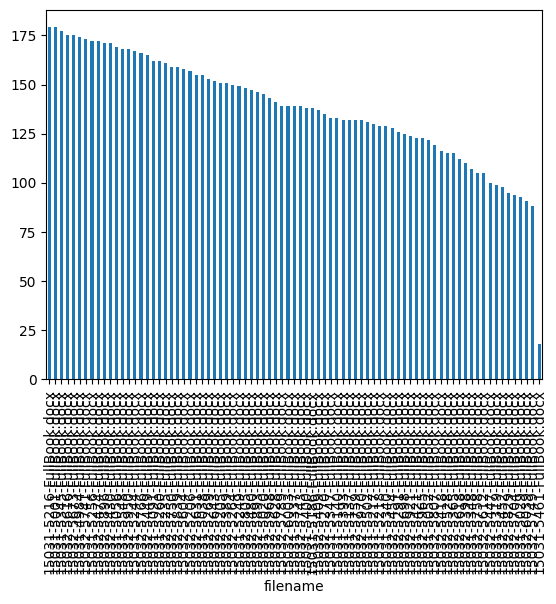

In [15]:
ploting = filtered_df["filename"].value_counts()
ploting.plot.bar(x='filename', rot=90)

In [16]:
level1_train = filtered_df[filtered_df["labels"]=="Level 1"]["filename"].unique()[:20]
level2_train = filtered_df[filtered_df["labels"]=="Level 2"]["filename"].unique()[:20]
level3_train = filtered_df[filtered_df["labels"]=="Level 3"]["filename"].unique()[:20]

level1_val= filtered_df[filtered_df["labels"]=="Level 1"]["filename"].unique()[20:]
level2_val = filtered_df[filtered_df["labels"]=="Level 2"]["filename"].unique()[20:]
level3_val = filtered_df[filtered_df["labels"]=="Level 3"]["filename"].unique()[20:]

In [17]:
train_indices = []
for index in range(filtered_df.shape[0]):
  f_name = filtered_df.iloc[index]["filename"]
  if f_name in level1_train or f_name in level2_train or f_name in level3_train:
    train_indices.append(index)

val_indices = []
for index in range(filtered_df.shape[0]):
  f_name = filtered_df.iloc[index]["filename"]
  if f_name in level1_val or f_name in level2_val or f_name in level3_val:
    val_indices.append(index)

In [18]:
len(train_indices), len(val_indices)

(8303, 2890)

In [19]:
new_train_df = new_chunk_df.iloc[train_indices].copy()
new_val_df = new_chunk_df.iloc[val_indices].copy()


<Axes: xlabel='filename'>

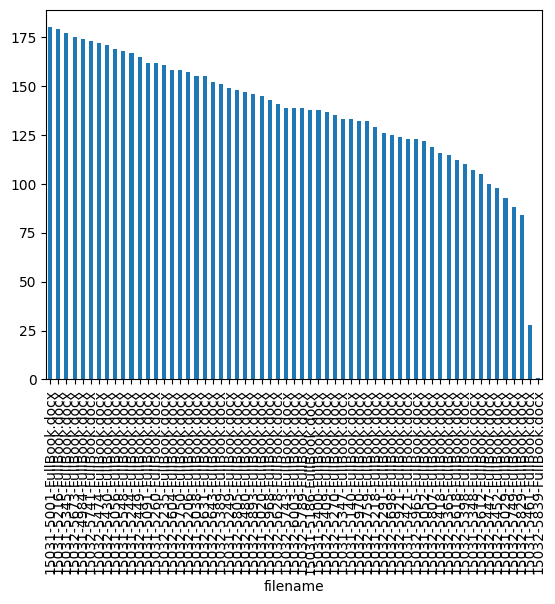

In [20]:
new_train_df["filename"].value_counts().plot(kind="bar",rot=90)

In [21]:
new_train_df["labels"].value_counts()

labels
Level 2    3002
Level 1    2774
Level 3    2527
Name: count, dtype: int64

In [22]:
new_train_df

,filename,texts,labels,chunks
0,15031-5421-FullBook.docx,Clinical Cases in Augmentative and Alternative...,Level 1,chunk_0
1,15031-5421-FullBook.docx,British Library Cataloguing-in-Publication Dat...,Level 1,chunk_1
2,15031-5421-FullBook.docx,"I hope, therefore, that readers enjoy this lat...",Level 1,chunk_2
3,15031-5421-FullBook.docx,Sally is a Senior Lecturer in Speech and Langu...,Level 1,chunk_3
4,15031-5421-FullBook.docx,"Nancy Harrington, M.A., CCC-SLP, ATP, is a spe...",Level 1,chunk_4
...,...,...,...,...
10258,15032-5829-FullBook.docx,This explains the prevalence of the term guomi...,Level 3,chunk_79
10259,15032-5829-FullBook.docx,"China, as it is known today, only became the o...",Level 3,chunk_80
10260,15032-5829-FullBook.docx,"Northwest Journal of Ethnicity ( 西北民族研究 ), 95 ...",Level 3,chunk_81
10261,15032-5829-FullBook.docx,Drawing on Spencer’s (2008; 2012) and Radcliff...,Level 3,chunk_82


In [23]:
new_train_df.to_csv('/home/ubuntu/working_directory/Bert_experimentation/train_new.csv')

In [25]:
new_val_df.to_csv('/home/ubuntu/working_directory/Bert_experimentation/val_new.csv')

In [71]:
# for i in final_chunks:
#     print(i)
#     print(len(i.split(' ')))